In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/ec2-user/sustaingym


In [4]:
import numpy as np
import onnxruntime as rt
import pandas as pd

from sustaingym.data.cogen.load_ambients import construct_df
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

In [5]:
dfs = construct_df(renewables_magnitude=300.0)

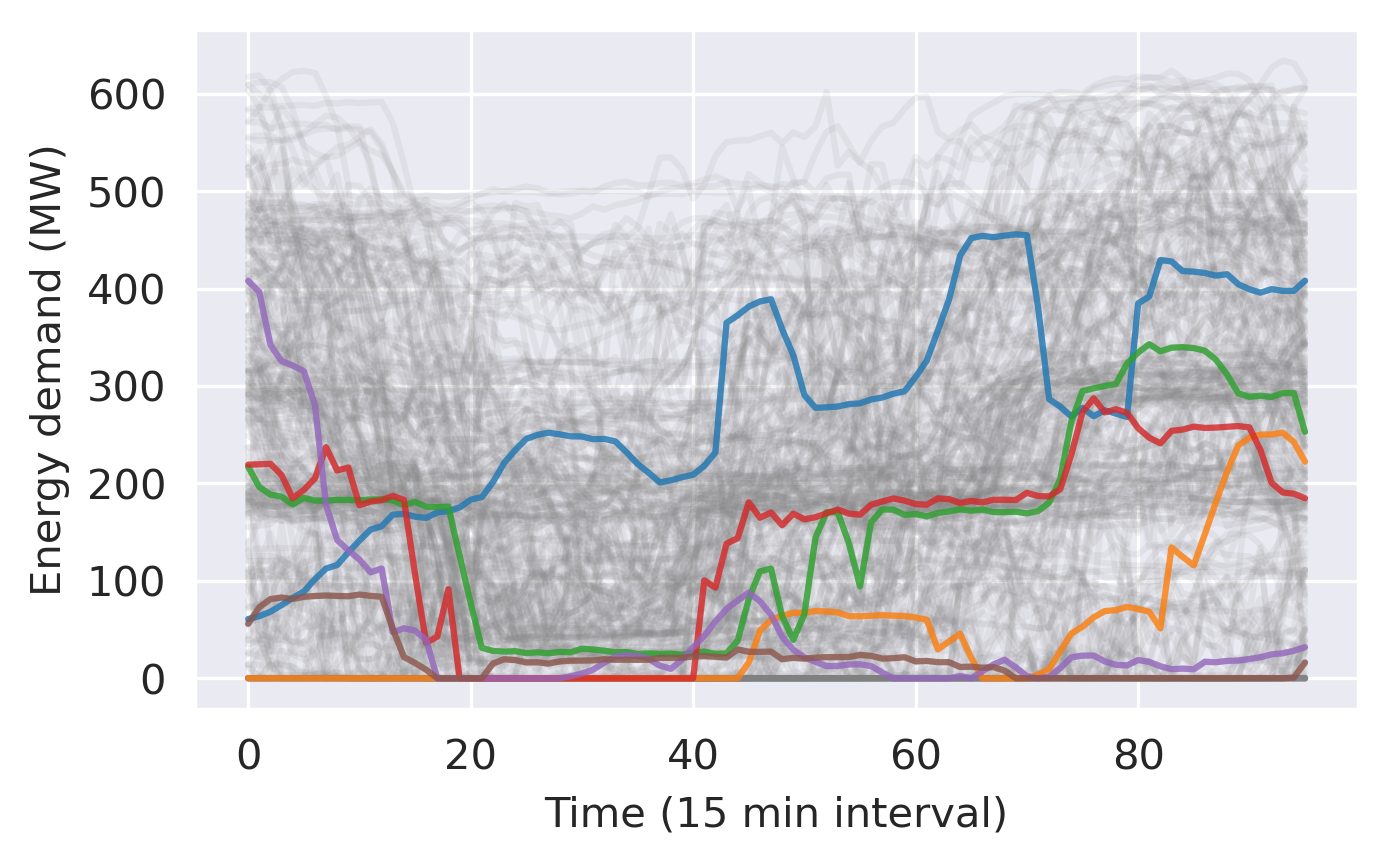

In [7]:
powers = np.array([dfs[i]['Target Net Power'].to_numpy() for i in range(len(dfs))])
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(powers.T, color='grey', alpha=0.1)
plt.plot(powers.T[:, ::50], alpha=0.8)
plt.xlabel('Time (15 min interval)')
plt.ylabel('Energy demand (MW)')
plt.savefig('energy_demand_with_wind.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
dfs[0].head()

In [ ]:
len(dfs)

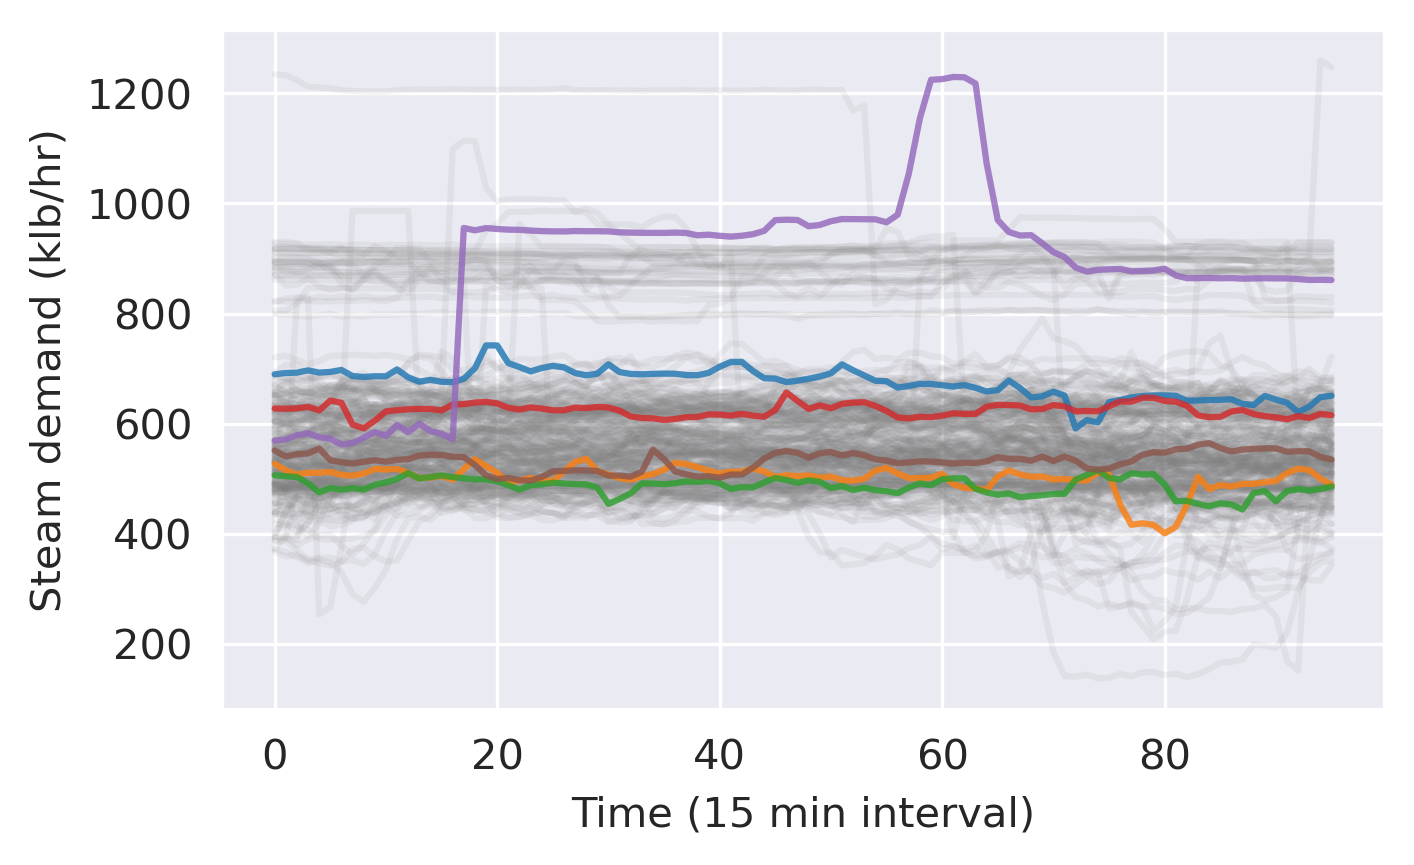

In [21]:
steams = np.array([dfs[i]['Target Process Steam'].to_numpy() for i in range(len(dfs))])
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(steams.T, color='grey', alpha=0.1)
plt.plot(steams.T[:, ::50], alpha=0.8)
plt.xlabel('Time (15 min interval)')
plt.ylabel('Steam demand (klb/hr)')
plt.savefig('steam_demand.pdf', bbox_inches='tight')
plt.show()

In [ ]:
save_dir = 'ambients_data/'

# load the ambients dataset
df = pd.read_excel(save_dir + 'operating_data.xlsx',
                header=3)
df = df.iloc[:, [0, 1, 2, 7, 8, 9]]
df['Date'] = df.apply(lambda row: row.Timestamp.date(), axis=1)
dates = df.Date.unique()
# # drop the first and last days so each day has 96 datapoints
# dfs = [df[df['Date'] == val] for val in dates][1:-1]
# # exclude any day that has more or fewer than 96 intervals
# # since this means the row is corrupted (fix this later TODO)
# dfs = [val for val in dfs if len(val) == 96]

# load the electricity price datasets
sheet_to_df_map_2021 = pd.read_excel(save_dir + 'rpt.00013060.0000000000000000.DAMLZHBSPP_2021.xlsx', sheet_name=None)
sheet_to_df_map_2022 = pd.read_excel(save_dir + 'rpt.00013060.0000000000000000.DAMLZHBSPP_2022.xlsx', sheet_name=None)
energy_df = pd.concat([df[df['Settlement Point'] == 'HB_HOUSTON'] for df in sheet_to_df_map_2021.values()]
                        + [df[df['Settlement Point'] == 'HB_HOUSTON'] for df in sheet_to_df_map_2022.values()])

# # modify the hour ending column to be hour beginning
energy_df['Hour Ending'] = energy_df['Hour Ending'].apply(lambda x: int(x[:2])-1)
energy_df.rename(columns={'Hour Ending': 'Hour Beginning'}, inplace=True)

# convert the date and hour beginning columns to a single datetime
energy_df['Delivery Date'] = pd.to_datetime(energy_df['Delivery Date'])
energy_df['Hour Beginning'] = energy_df.apply(lambda row: row['Delivery Date'] + pd.Timedelta(hours=row['Hour Beginning']), axis=1)
energy_df.drop(columns=['Delivery Date'], inplace=True)

# get days in energy_df with more or fewer than 24 hours (due to daylight savings)
idxs = energy_df['Hour Beginning'].apply(lambda x: x.date()).value_counts()
idxs = idxs[idxs != 24].index

# remove the days from energy_df in idxs
energy_df = energy_df[~energy_df['Hour Beginning'].apply(lambda x: x.date()).isin(idxs)]

# subsample every 15 minutes
energy_df.set_index('Hour Beginning', inplace=True)
energy_df_15min = energy_df.resample('15min').ffill()

# load the gas spot price dataset
gas_df = pd.read_csv(save_dir + 'Henry_Hub_Natural_Gas_Spot_Price.csv',
                    sep=',', header=4)
gas_df['Day'] = pd.to_datetime(gas_df['Day'])

# add the column "Settlement Point Price" from energy_df_15min to df only
# if df has the date and time in its Timestamp column
df['Energy Price'] = df.apply(lambda row: energy_df_15min.loc[row.Timestamp]['Settlement Point Price'], axis=1)

# add days to gas_df that are missing
gas_df = gas_df.set_index('Day')
gas_df = gas_df.reindex(pd.date_range(start=gas_df.index.min(), end=gas_df.index.max(), freq='D'))

# fill in NaNs with the previous day's price
gas_df = gas_df.fillna(method='ffill')

# subsample gas_df every 15 minutes
gas_df_15min = gas_df.resample('15min').ffill()

# add the column "Henry Hub Natural Gas Spot Price Dollars per Million Btu" from gas_df_15min to df only
# if df has the date and time in its Timestamp column
df['Gas Price'] = df.apply(lambda row: gas_df_15min.loc[row.Timestamp]['Henry Hub Natural Gas Spot Price Dollars per Million Btu'], axis=1)


In [ ]:
len(dfs[0])

In [ ]:
df['Gas Price'].iloc[0:10].to_list()